In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# 1. Load Dataset
df = pd.read_csv('/content/drive/MyDrive/UTS pembelajran mendalam /water_potability.csv')

In [ ]:
# 2. DATA PREPARATION (PREPROCESSING)
# ==========================================================
# Mengisi nilai yang kosong dengan rata-rata (Mean Imputation)
# Solusi agar model tidak error karena data kosong
df.fillna(df.mean(), inplace=True)

# Memisahkan Fitur dan Target
X = df.drop('Potability', axis=1)
y = df['Potability']

# Scaling Data (MinMaxScaler) - Menyamakan rentang nilai agar model stabil
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split Data (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Data Siap! Training: {len(X_train)}, Testing: {len(X_test)}")


✅ Data Siap! Training: 2620, Testing: 656


In [ ]:
# 3. Pengujian 3 Model (Random Forest, SVM (Support Vector Machine), dan K-Nearest Neighbors (KNN).)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "SVM (Support Vector Machine)": SVC(probability=True, kernel='rbf', random_state=42),
    "KNN (K-Nearest Neighbors)": KNeighborsClassifier(n_neighbors=9)
}

# Training dan Evaluasi
best_acc = 0
best_model = None
best_model_name = ""

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n--- Model: {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_model_name = name


--- Model: Random Forest ---
Accuracy: 0.6616
              precision    recall  f1-score   support

           0       0.65      0.95      0.77       400
           1       0.72      0.21      0.33       256

    accuracy                           0.66       656
   macro avg       0.69      0.58      0.55       656
weighted avg       0.68      0.66      0.60       656


--- Model: SVM (Support Vector Machine) ---
Accuracy: 0.6616
              precision    recall  f1-score   support

           0       0.66      0.94      0.77       400
           1       0.71      0.23      0.34       256

    accuracy                           0.66       656
   macro avg       0.68      0.58      0.56       656
weighted avg       0.68      0.66      0.60       656


--- Model: KNN (K-Nearest Neighbors) ---
Accuracy: 0.6128
              precision    recall  f1-score   support

           0       0.64      0.83      0.72       400
           1       0.51      0.27      0.36       256

    accuracy  

In [ ]:
# 4. SIMPAN MODEL TERBAIK UNTUK WEBSITE
# ==========================================================
print(f"\n🏆 Model Terbaik: {best_model_name} dengan Akurasi {best_acc:.4f}")

# Simpan model dan scaler ke file .pkl
with open('model_air.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler_air.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("💾 Model dan Scaler telah disimpan sebagai model_air.pkl dan scaler_air.pkl")


🏆 Model Terbaik: Random Forest dengan Akurasi 0.6616
💾 Model dan Scaler telah disimpan sebagai model_air.pkl dan scaler_air.pkl


In [ ]:
import os
import pandas as pd

# 5. CEK LOKASI FILE DATASET
# ==========================================================
def find_csv_path(filename):
    for root, dirs, files in os.walk('/content'): # Mencari di direktori Colab
        if filename in files:
            return os.path.join(root, filename)
    return None

FILE_NAME = 'water_potability.csv'
PATH_DATASET = find_csv_path(FILE_NAME)

if PATH_DATASET:
    df = pd.read_csv(PATH_DATASET)
    print(f"✅ Dataset ditemukan di: {PATH_DATASET}")
    print(f"📊 Jumlah Data: {df.shape[0]} baris, {df.shape[1]} kolom")
    print(f"📂 Kolom yang tersedia: {list(df.columns)}")
else:
    print(f"❌ File {FILE_NAME} tidak ditemukan. Silakan upload ke Google Colab.")

# Melihat 5 data teratas
df.head()

✅ Dataset ditemukan di: /content/drive/MyDrive/UTS pembelajran mendalam /water_potability.csv
📊 Jumlah Data: 3276 baris, 10 kolom
📂 Kolom yang tersedia: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


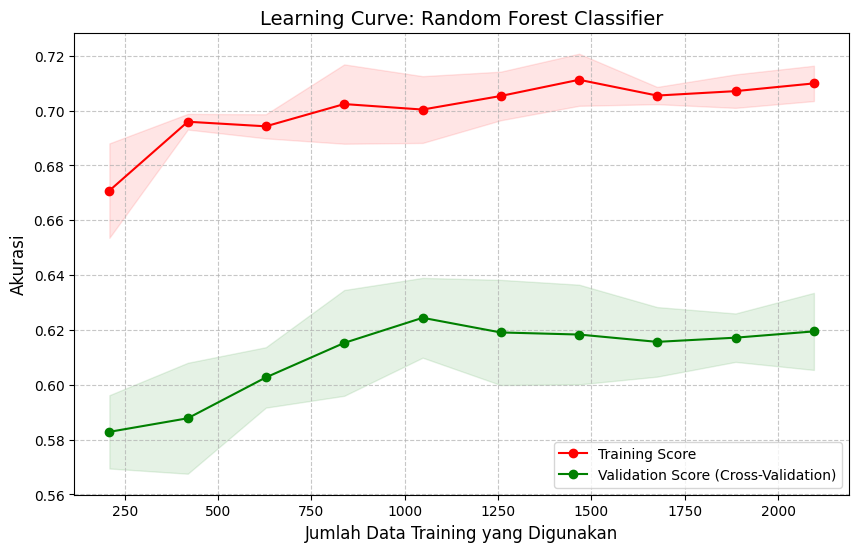

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# ==========================================================
## A. GRAFIK PERFORMA RANDOM FOREST (Learning Curve)
# Digunakan untuk mendeteksi Overfitting pada Random Forest
# ==========================================================

def plot_learning_curve(estimator, title, X, y):
    # n_jobs=-1 menggunakan semua prosesor agar training lebih cepat
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy',
        random_state=42
    )

    # Menghitung rata-rata dan standar deviasi skor
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))

    # Plot Training Score (Warna Merah)
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")

    # Plot Validation Score (Warna Hijau)
    plt.plot(train_sizes, val_mean, 'o-', color="g", label="Validation Score (Cross-Validation)")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")

    plt.title(f'Learning Curve: {title}', fontsize=14)
    plt.xlabel('Jumlah Data Training yang Digunakan', fontsize=12)
    plt.ylabel('Akurasi', fontsize=12)
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Pastikan 'best_model_obj' adalah Random Forest dari proses sebelumnya
# Jika ingin mendefinisikan ulang secara manual:
# best_model_obj = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
# best_model_name = "Random Forest"

plot_learning_curve(best_model_obj, "Random Forest Classifier", X_train, y_train)

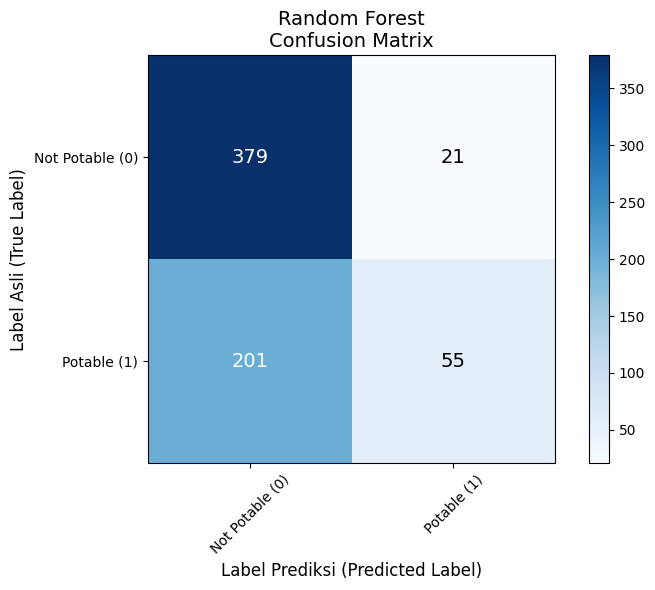

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================================
## B. CONFUSION MATRIX - RANDOM FOREST
# ==========================================================

# Nama model yang konsisten dengan dictionary hasil training Anda
name_rf = "Random Forest"

# Mengambil data CM khusus dari model Random Forest
if name_rf in results:
    cm = results[name_rf]['Confusion_Matrix']
else:
    # Fallback jika nama di dictionary berbeda
    cm = confusion_matrix(y_test, models[name_rf].predict(X_test))

plt.figure(figsize=(8, 6))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'{name_rf}\nConfusion Matrix', fontsize=14)
plt.colorbar()

# Label khusus untuk Water Potability (0: Tidak Layak, 1: Layak)
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Potable (0)', 'Potable (1)'], rotation=45)
plt.yticks(tick_marks, ['Not Potable (0)', 'Potable (1)'])

plt.ylabel('Label Asli (True Label)', fontsize=12)
plt.xlabel('Label Prediksi (Predicted Label)', fontsize=12)

# Menambahkan teks angka di dalam kotak matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

plt.tight_layout()
plt.show()

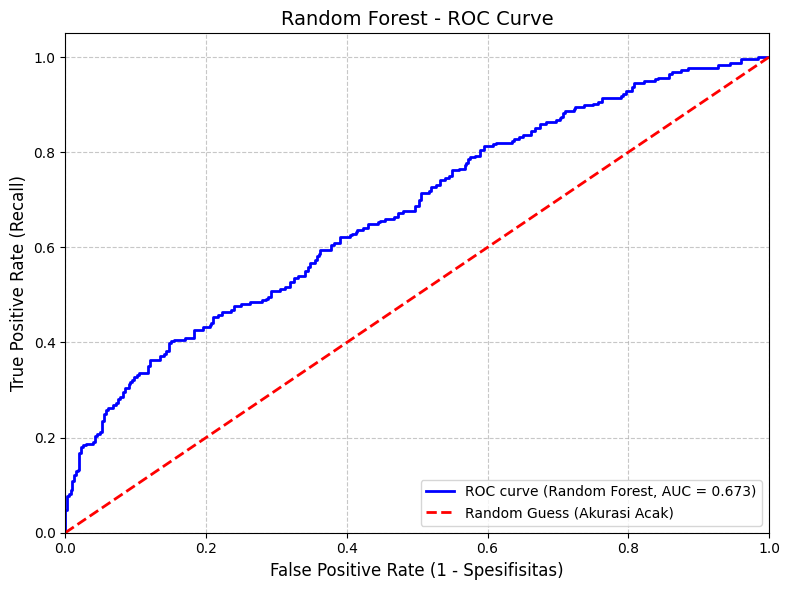

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ==========================================================
## C. KURVA ROC - RANDOM FOREST
# ==========================================================

# 1. Pastikan mengambil data probabilitas khusus model Random Forest
name_rf = "Random Forest"

# Mengambil probabilitas prediksi untuk kelas 1 (Potable)
# Kita asumsikan 'model_rf' atau 'models[name_rf]' adalah objek modelnya
y_prob_rf = models[name_rf].predict_proba(X_test)[:, 1]

# 2. Hitung False Positive Rate (fpr) dan True Positive Rate (tpr)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = results[name_rf]['AUC']

# 3. Plotting (Gunakan plt.subplot(1, 3, 3) jika ingin digabung dengan Grafik A dan B)
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve ({name_rf}, AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess (Akurasi Acak)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Spesifisitas)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title(f'{name_rf} - ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()